# Курсовой проект для курса "Python для Data Science"

Задание:
Используя данные из обучающего датасета (train.csv), построить модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели, предсказать цены для квартир из тестового датасета (test.csv).

Целевая переменная:
Price

Метрика качества:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)
Требования к решению:
1. R2 > 0.6
2. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}_solution.ipynb, пример SShirkin_solution.ipynb
3. Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}_predictions.csv, пример SShirkin_predictions.csv 
Файл должен содержать два поля: Id, Price и в файле должна быть 5001 строка (шапка + 5000 предсказаний).

### Подключение библиотек и скриптов

In [213]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [214]:
import warnings
warnings.filterwarnings('ignore')

In [215]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    """
    #Функция для отображения результатов предсказания модели и оценки их качества по метрике R2

    """
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))

    plt.figure(figsize=(18,10))
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

### Пути к файлам датасета

In [216]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'

 ### Загрузка и оптимизация типов данных

In [217]:
train = pd.read_csv(TRAIN_DATASET_PATH, sep=',')
train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [218]:
test = pd.read_csv(TEST_DATASET_PATH, sep=',')
test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


In [219]:
train.shape, test.shape

((10000, 20), (5000, 19))

Функция для оптимизации типа данных:

In [220]:
def optimizing_df(df):
    for col in df.columns:
        if df[col].dtypes.kind == 'i' or df[col].dtypes.kind == 'u':
            if df[col].min() >= 0:
                df[col] = pd.to_numeric(df[col], downcast='unsigned')
            else:
                df[col] = pd.to_numeric(df[col], downcast='integer')

        elif df[col].dtypes.kind == 'f' or df[col].dtypes.kind == 'c':
            df[col] = pd.to_numeric(df[col], downcast='float')

        elif df[col].dtypes.kind == 'O':
            num_unique_values = len(df[col].unique())
            num_total_values = len(df[col])
            if num_unique_values / num_total_values < 0.5:
                df[col] = df[col].astype('category')

    return df

In [221]:
optimizing_df(train)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981560,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.937500
1,15053,41,3.0,65.683640,40.049541,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.437500
2,4765,53,2.0,44.947952,29.197611,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.906250
3,5809,58,2.0,53.352982,52.731510,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.234375
4,10783,99,1.0,39.649193,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,77,32,2.0,50.401787,30.476204,5.0,6,5.0,1968,0.135650,B,B,46,7960,6,350.0,3,11,B,196684.312500
9996,6159,18,1.0,41.521545,20.539215,9.0,13,13.0,2000,0.000000,B,B,30,5562,0,NaN,0,5,A,189050.296875
9997,5123,27,1.0,47.939007,NaN,1.0,12,16.0,2015,0.072158,B,B,2,629,1,NaN,0,0,A,159143.812500
9998,5400,75,2.0,43.602562,33.840149,8.0,1,5.0,1961,0.307467,B,A,30,5048,9,325.0,2,5,B,181595.343750


In [222]:
optimizing_df(test)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882645,33.432781,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263184,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597818,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046608,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,8180,11,3.0,67.133911,50.809795,6.0,5,9.0,1973,0.000170,B,B,36,5992,0,NaN,1,1,B
4996,4695,1,1.0,40.198471,21.807060,10.0,12,17.0,2017,0.007122,B,B,1,264,0,NaN,0,1,B
4997,5783,12,3.0,77.842178,48.282623,9.0,23,22.0,1989,0.090799,B,B,74,19083,2,NaN,5,15,B
4998,4780,62,2.0,81.305222,NaN,0.0,4,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A


### Первичный обзор данных

In [223]:
train.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315712,37.199596,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214139.218750
std,4859.01902,43.587592,0.839523,21.058718,86.241112,28.561113,5.241148,6.776192,2.005003e+05,0.119026,17.532614,4006.799803,23.831875,1021.518982,1.493601,4.806341,92872.304688
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,4169.50000,20.000000,1.000000,41.774879,22.769833,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,8394.50000,36.000000,2.000000,52.513309,32.781261,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,12592.50000,75.000000,2.000000,65.900627,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,16798.00000,209.000000,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


In [224]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  uint16  
 1   DistrictId     10000 non-null  uint8   
 2   Rooms          10000 non-null  float32 
 3   Square         10000 non-null  float32 
 4   LifeSquare     7887 non-null   float32 
 5   KitchenSquare  10000 non-null  float32 
 6   Floor          10000 non-null  uint8   
 7   HouseFloor     10000 non-null  float32 
 8   HouseYear      10000 non-null  uint32  
 9   Ecology_1      10000 non-null  float32 
 10  Ecology_2      10000 non-null  category
 11  Ecology_3      10000 non-null  category
 12  Social_1       10000 non-null  uint8   
 13  Social_2       10000 non-null  uint16  
 14  Social_3       10000 non-null  uint8   
 15  Healthcare_1   5202 non-null   float32 
 16  Helthcare_2    10000 non-null  uint8   
 17  Shops_1        10000 non-null  u

In [225]:
train.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [226]:
test.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.000000,5000.000000,5000.000000,3959.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000
mean,8412.595400,51.279200,1.910000,56.449501,36.158760,5.976800,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1146.657227,1.31940,4.242800
std,4832.674037,44.179466,0.838587,19.092793,17.825277,9.950147,5.483228,6.789167,18.573149,0.120070,17.532202,4026.614773,23.863762,1044.744995,1.47994,4.777365
min,1.000000,0.000000,0.000000,1.378543,0.333490,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,4221.750000,21.000000,1.000000,41.906230,23.092026,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000
50%,8320.500000,37.000000,2.000000,52.921339,32.925087,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,12598.250000,77.000000,2.000000,66.285130,45.174091,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000
max,16795.000000,212.000000,17.000000,223.453690,303.071106,620.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


In [227]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             5000 non-null   uint16  
 1   DistrictId     5000 non-null   uint8   
 2   Rooms          5000 non-null   float32 
 3   Square         5000 non-null   float32 
 4   LifeSquare     3959 non-null   float32 
 5   KitchenSquare  5000 non-null   float32 
 6   Floor          5000 non-null   uint8   
 7   HouseFloor     5000 non-null   float32 
 8   HouseYear      5000 non-null   uint16  
 9   Ecology_1      5000 non-null   float32 
 10  Ecology_2      5000 non-null   category
 11  Ecology_3      5000 non-null   category
 12  Social_1       5000 non-null   uint8   
 13  Social_2       5000 non-null   uint16  
 14  Social_3       5000 non-null   uint8   
 15  Healthcare_1   2623 non-null   float32 
 16  Helthcare_2    5000 non-null   uint8   
 17  Shops_1        5000 non-null   ui

In [228]:
test.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       1041
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     2377
Helthcare_2         0
Shops_1             0
Shops_2             0
dtype: int64

#### Целевая переменная

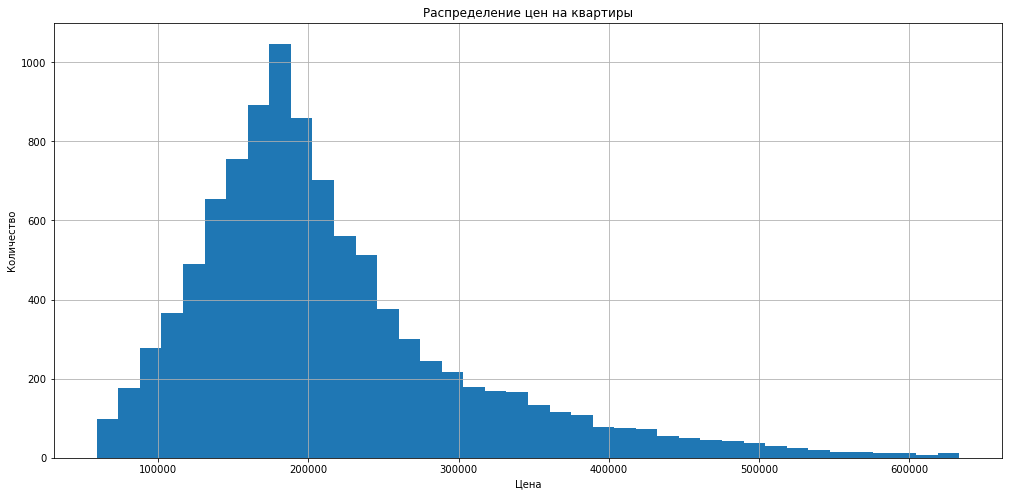

In [229]:
plt.figure(figsize = (17, 8))

train['Price'].hist(bins=40)
plt.ylabel('Количество')
plt.xlabel('Цена')

plt.title('Распределение цен на квартиры')
plt.show()

Распределение цен на квартиры в тренировочном датасете близко к нормальному. Явных выбросов не наблюдается.

#### Построение матрицы корреляций

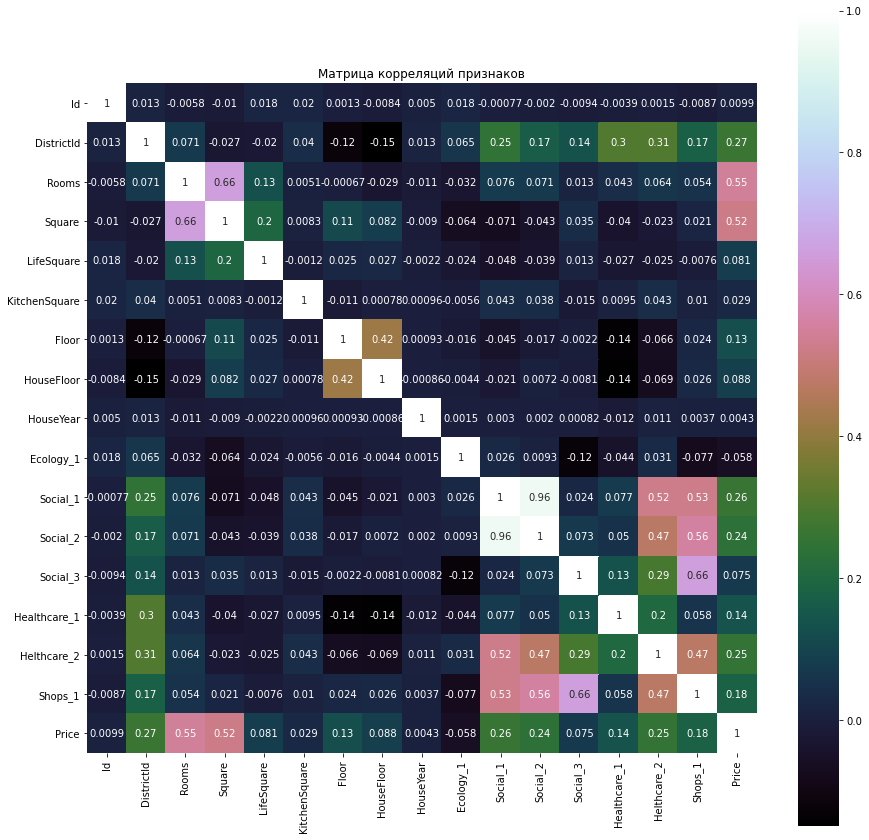

In [230]:
correlation = train.corr()
plt.figure(figsize=(15,15))
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

plt.title('Матрица корреляций признаков')
plt.show()

Высоко коррелируют между собой признаки Social_1 и Social_2, а также площадь квартиры и количество комнат в ней, социальные признаки и признаки наличия магазинов в районе.

В признаке LifeSquare 20% пропусков в обоих датасетах, также этот признак достаточно высоко коррелирует с общей площадью квартиры. Поэтому исключаем его из тренировочного и тестового датасетов.

In [231]:
train = train.drop('LifeSquare', axis=1)
test = test.drop('LifeSquare', axis=1)

In [232]:
train.shape, test.shape

((10000, 19), (5000, 18))

#### Категориальные переменные

In [233]:
train_cat_features = train.select_dtypes(include='category')
train_cat_features.head()

,Ecology_2,Ecology_3,Shops_2
0,B,B,B
1,B,B,B
2,B,B,B
3,B,B,B
4,B,B,B


In [234]:
train_cat_features.value_counts()

Ecology_2  Ecology_3  Shops_2
B          B          B          8817
                      A           811
           A          B           275
A          B          B            83
                      A            14
dtype: int64

В категориальных признаках пропусков нет, только значения A и B.
Аналогично проверим датасет test.

In [235]:
test_cat_features = test.select_dtypes(include='category')
test_cat_features.head()

,Ecology_2,Ecology_3,Shops_2
0,B,B,B
1,B,B,B
2,B,B,B
3,B,B,B
4,B,B,A


In [236]:
test_cat_features.value_counts()

Ecology_2  Ecology_3  Shops_2
B          B          B          4400
                      A           403
           A          B           149
A          B          B            39
                      A             9
dtype: int64

### Обработка выбросов

#### Rooms

In [237]:
train['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
6.0        1
19.0       1
Name: Rooms, dtype: int64

Заменим наблюдения для значений 10 и 19 на медиану. Значение 0 будем считать обозначением квартир-студий.

In [238]:
train.loc[train['Rooms'].isin([10, 19]), 'Rooms'] = int(train['Rooms'].median())

#### Square, KitchenSquare

Для этих признаков уберем выбросы за пределами 1-го и 99-го квантилей.

In [239]:
train = train[train['Square'].isnull() |
                    (train['Square'] < train['Square'].quantile(.99)) &
                    (train['Square'] > train['Square'].quantile(.01))]

train = train[train['KitchenSquare'].isnull() |
                    (train['KitchenSquare'] < train['KitchenSquare'].quantile(.99)) &
                    (train['KitchenSquare'] > train['KitchenSquare'].quantile(.01))]

In [240]:
train.describe()

,Id,DistrictId,Rooms,Square,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,9014.000000,9014.000000,9014.000000,9014.000000,9014.000000,9014.000000,9014.000000,9.014000e+03,9014.000000,9014.000000,9014.000000,9014.000000,4855.000000,9014.000000,9014.000000,9014.000000
mean,8396.420568,51.835700,1.889949,55.127014,6.024074,8.468715,12.818061,4.209427e+03,0.119462,25.975594,5615.430996,8.367983,1150.647583,1.384180,4.430663,215484.937500
std,4870.212028,44.321618,0.801990,16.563469,3.528518,5.152083,6.421804,2.111816e+05,0.119375,17.297838,3985.337088,24.290392,1030.422852,1.490403,4.840564,90341.929688
min,2.000000,0.000000,0.000000,29.719934,1.000000,1.000000,0.000000,1.914000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,4168.500000,20.000000,1.000000,41.701714,1.000000,4.000000,9.000000,1.972250e+03,0.017647,9.000000,2277.000000,0.000000,325.000000,0.000000,1.000000,156911.726562
50%,8404.500000,39.000000,2.000000,51.884691,6.000000,7.000000,14.000000,1.977000e+03,0.075779,25.000000,5562.000000,2.000000,990.000000,1.000000,3.000000,194417.687500
75%,12630.250000,79.000000,2.000000,65.070711,9.000000,12.000000,17.000000,2.001000e+03,0.194489,36.000000,7614.000000,5.000000,1548.000000,3.000000,6.000000,250819.570312
max,16798.000000,209.000000,6.000000,117.855972,14.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


#### Floor, HouseFloor

In [241]:
train['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 42],
      dtype=uint8)

In [242]:
train['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  32.,  37.,
        39.,  40.,  44.,  45.,  48.,  99., 117.], dtype=float32)

В признаке HouseFloor заменим нули и значения больше 50 на медиану.

In [243]:
train.loc[(train['HouseFloor'] == 0) & (train['HouseFloor'] > 50), 'HouseFloor'] = train['HouseFloor'].median()

Для случаев, когда этаж квартиры превышает этажность дома, заменим значения на количество этажей в доме.

In [244]:
np.random.seed(42)
floor_wrong = train[train['Floor'] > train['HouseFloor']].index
print(len(floor_wrong))

train.loc[floor_wrong, 'Floor'] = train.loc[floor_wrong, 'HouseFloor']

1469


#### HouseYear

In [245]:
train['HouseYear'].value_counts().sort_index()

1914          1
1916          1
1917          3
1918          4
1919          3
           ... 
2018        146
2019         62
2020         19
4968          1
20052011      1
Name: HouseYear, Length: 95, dtype: int64

Заменим некорректные значения

In [246]:
train.loc[train['HouseYear'] == 4968, 'HouseYear'] = 1968
train.loc[train['HouseYear'] == 20052011, 'HouseYear'] = 2011

### Обработка пропусков

In [247]:
len(train) - train.count()

Id                  0
DistrictId          0
Rooms               0
Square              0
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4159
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

Заменим пропуски для признака Healthcare_1 на медиану.

In [248]:
train.loc[train['Healthcare_1'].isnull(), 'Healthcare_1'] = train['Healthcare_1'].median()

### Построение новых признаков

#### Dummies

In [249]:
train['Ecology_2_bin'] = train['Ecology_2'].replace({'A':0, 'B':1})
train['Ecology_3_bin'] = train['Ecology_3'].replace({'A':0, 'B':1})
train['Shops_2_bin'] = train['Shops_2'].replace({'A':0, 'B':1})

#### DistrictSize

In [250]:
district_size = train['DistrictId'].value_counts(normalize=True).reset_index()\
               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
district_size.head()

,DistrictId,DistrictSize
0,27,0.071999
1,1,0.060351
2,23,0.050810
3,6,0.045374
4,9,0.032172


In [251]:
train = train.merge(district_size, on='DistrictId', how='left')
train.head()

,Id,DistrictId,Rooms,Square,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize
0,14038,35,2.0,47.981560,6.0,7.0,9.0,1969,0.089040,B,...,5,990.0,0,11,B,184966.937500,1,1,1,0.002219
1,15053,41,3.0,65.683640,8.0,7.0,9.0,1978,0.000070,B,...,1,240.0,1,16,B,300009.437500,1,1,1,0.009541
2,5809,58,2.0,53.352982,9.0,8.0,17.0,1977,0.437885,B,...,3,1084.0,0,5,B,175616.234375,1,1,1,0.016641
3,10783,99,1.0,39.649193,7.0,11.0,12.0,1976,0.012339,B,...,1,2078.0,2,4,B,150226.531250,1,1,1,0.010539
4,12915,59,3.0,80.384476,12.0,5.0,17.0,2011,0.309479,B,...,4,990.0,0,6,B,215898.453125,1,1,1,0.005991


#### MedPriceByDistrict

In [252]:
med_price_by_district = train.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                       .rename(columns={'Price':'MedPriceByDistrict'})

med_price_by_district.head()

,DistrictId,Rooms,MedPriceByDistrict
0,0,1.0,147258.734375
1,0,2.0,176210.812500
2,0,3.0,300610.375000
3,1,1.0,146341.750000
4,1,2.0,202954.125000


In [253]:
train = train.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
train.head()

,Id,DistrictId,Rooms,Square,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,MedPriceByDistrict
0,14038,35,2.0,47.981560,6.0,7.0,9.0,1969,0.089040,B,...,990.0,0,11,B,184966.937500,1,1,1,0.002219,203384.328125
1,15053,41,3.0,65.683640,8.0,7.0,9.0,1978,0.000070,B,...,240.0,1,16,B,300009.437500,1,1,1,0.009541,300009.437500
2,5809,58,2.0,53.352982,9.0,8.0,17.0,1977,0.437885,B,...,1084.0,0,5,B,175616.234375,1,1,1,0.016641,169246.125000
3,10783,99,1.0,39.649193,7.0,11.0,12.0,1976,0.012339,B,...,2078.0,2,4,B,150226.531250,1,1,1,0.010539,158791.015625
4,12915,59,3.0,80.384476,12.0,5.0,17.0,2011,0.309479,B,...,990.0,0,6,B,215898.453125,1,1,1,0.005991,384517.562500


#### Подготовка датафрейма test

In [254]:
test['Ecology_2_bin'] = test['Ecology_2'].replace({'A':0, 'B':1})
test['Ecology_3_bin'] = test['Ecology_3'].replace({'A':0, 'B':1})
test['Shops_2_bin'] = test['Shops_2'].replace({'A':0, 'B':1})

In [255]:
district_size = test['DistrictId'].value_counts(normalize=True).reset_index()\
               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
district_size.head()

,DistrictId,DistrictSize
0,27,0.0782
1,1,0.0688
2,23,0.0528
3,6,0.0514
4,9,0.0264


In [256]:
test = test.merge(district_size, on='DistrictId', how='left')
test.head()

,Id,DistrictId,Rooms,Square,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize
0,725,58,2.0,49.882645,6.0,6,14.0,1972,0.310199,B,...,2748,1,NaN,0,0,B,1,1,1,0.0182
1,15856,74,2.0,69.263184,1.0,6,1.0,1977,0.075779,B,...,1437,3,NaN,0,2,B,1,1,1,0.0122
2,5480,190,1.0,13.597818,12.0,2,5.0,1909,0.000000,B,...,7538,87,4702.0,5,5,B,1,1,1,0.0004
3,15664,47,2.0,73.046608,9.0,22,22.0,2007,0.101872,B,...,4583,3,NaN,3,3,B,1,1,1,0.0098
4,14275,27,1.0,47.527111,1.0,17,17.0,2017,0.072158,B,...,629,1,NaN,0,0,A,1,1,0,0.0782


In [257]:
test = test.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')

In [258]:
test.describe()

,Id,DistrictId,Rooms,Square,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,MedPriceByDistrict
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,4920.000000
mean,8412.595400,51.279200,1.910000,56.449501,5.976800,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1146.657227,1.31940,4.242800,0.990400,0.970200,0.917600,0.023107,210303.890625
std,4832.674037,44.179466,0.838587,19.092793,9.950147,5.483228,6.789167,18.573149,0.120070,17.532202,4026.614773,23.863762,1044.744995,1.47994,4.777365,0.097518,0.170052,0.275001,0.025476,70249.539062
min,1.000000,0.000000,0.000000,1.378543,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000200,78030.687500
25%,4221.750000,21.000000,1.000000,41.906230,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000,1.000000,1.000000,1.000000,0.005400,165478.890625
50%,8320.500000,37.000000,2.000000,52.921339,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000,1.000000,1.000000,1.000000,0.009800,197419.046875
75%,12598.250000,77.000000,2.000000,66.285130,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000,1.000000,1.000000,1.000000,0.051400,239606.500000
max,16795.000000,212.000000,17.000000,223.453690,620.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000,1.000000,1.000000,1.000000,0.078200,593618.750000


In [259]:
test.isna().sum()

Id                       0
DistrictId               0
Rooms                    0
Square                   0
KitchenSquare            0
Floor                    0
HouseFloor               0
HouseYear                0
Ecology_1                0
Ecology_2                0
Ecology_3                0
Social_1                 0
Social_2                 0
Social_3                 0
Healthcare_1          2377
Helthcare_2              0
Shops_1                  0
Shops_2                  0
Ecology_2_bin            0
Ecology_3_bin            0
Shops_2_bin              0
DistrictSize             0
MedPriceByDistrict      80
dtype: int64

Заменим пропуски в признаках Healthcare_1 и MedPriceByDistrict на медианы.

In [260]:
test.loc[test['Healthcare_1'].isnull(), 'Healthcare_1'] = test['Healthcare_1'].median()
test.loc[test['MedPriceByDistrict'].isnull(), 'MedPriceByDistrict'] = test['MedPriceByDistrict'].median()

In [261]:
train.shape, test.shape

((9014, 24), (5000, 23))

### Отбор признаков

In [262]:
train.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Ecology_2_bin',
 'Ecology_3_bin',
 'Shops_2_bin',
 'DistrictSize',
 'MedPriceByDistrict']

In [263]:
feature_names = ['Rooms', 'Square', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2_bin', 'Ecology_3_bin', 'Social_1', 'Social_2', 'Social_3',
                 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2_bin', 'DistrictSize', 'MedPriceByDistrict']
target_name = 'Price'

### Разбиение на train и test

In [264]:
X = train[feature_names]
y = train[target_name]

In [265]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, shuffle=True, random_state=42
)

### Построение модели

#### Обучение модели

In [266]:
rf = RandomForestRegressor(max_depth=12, min_samples_split=50, n_estimators=1000, n_jobs=-1, random_state=40)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=12, min_samples_split=50, n_estimators=1000,
                      n_jobs=-1, random_state=40)

#### Отложенная выборка

Train R2:	0.815
Test R2:	0.747


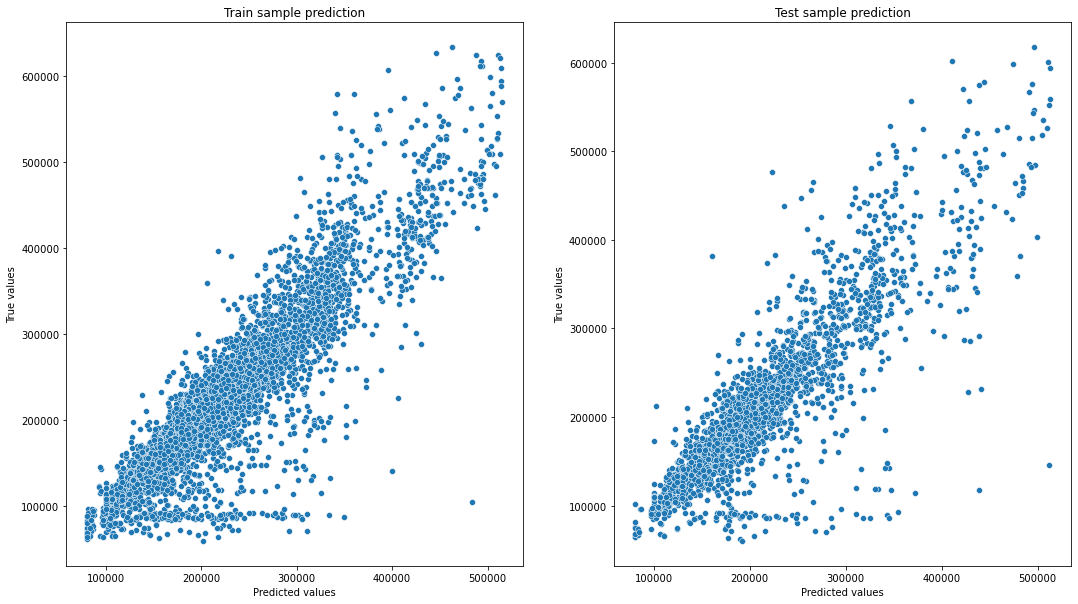

In [267]:
y_train_preds = rf.predict(X_train)
y_test_preds = rf.predict(X_test)

evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

#### Перекрестная проверка

In [268]:
cv_score = cross_val_score(
    rf,
    X.fillna(-9999),
    y, scoring='r2',
    cv=KFold(n_splits=6, shuffle=True, random_state=25)
)
cv_score

array([0.76038303, 0.73490804, 0.76107778, 0.72199263, 0.72736279,
       0.75233018])

In [269]:
cv_score.mean(), cv_score.std()

(0.7430090739966726, 0.015638305274476735)

Доверительный интервал эффективности модели по метрике R2

In [270]:
cv_score.mean() - cv_score.std(), cv_score.mean() + cv_score.std()

(0.7273707687221959, 0.7586473792711493)

#### Важность признаков

In [271]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
17,MedPriceByDistrict,0.749271
1,Square,0.109976
11,Social_3,0.020868
16,DistrictSize,0.019484
2,KitchenSquare,0.018387
5,HouseYear,0.015507
12,Healthcare_1,0.011173
10,Social_2,0.011152
4,HouseFloor,0.010883
6,Ecology_1,0.008611


### Формирование файла с прогнозами

In [272]:
X = test[feature_names]
y_pred = rf.predict(X)
y_pred

array([163918.42062717, 240239.74174824, 183949.06444763, ...,
       317123.7618112 , 200197.79542996, 174500.4430815 ])

In [273]:
test_id = test['Id']
pred_df = pd.DataFrame()
pred_df["Id"] = test_id
pred_df["Price"] = y_pred
pred_df.head()

,Id,Price
0,725,163918.420627
1,15856,240239.741748
2,5480,183949.064448
3,15664,299081.378276
4,14275,139282.362890


In [274]:
assert pred_df.shape[0] == 5000, f"Real pred-shape = {pred_df.shape[0]}, Expected pred-shape = 5000"
pred_df.to_csv("./RSentyabrev_predictions_.csv", index=False)